In [1]:
# Dependencies
import matplotlib.pyplot as plt
import requests
import pandas as pd
from scipy.stats import linregress
from config import tmdb_api_key
from config import omdb_api_key
import json
import numpy as np
import cpi
import time

In [2]:
# Check that the CSV was read properly
movie_import = pd.read_csv("movies_metadata.csv", low_memory=False)
print(movie_import.shape)
movie_import.head()

(45466, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
2,False,"{'id': 119050, 'name': 'Grumpy Old Men Collect...",0,"[{'id': 10749, 'name': 'Romance'}, {'id': 35, ...",NaN,15602,tt0113228,en,Grumpier Old Men,A family wedding reignites the ancient feud be...,...,1995-12-22,0.0,101.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Still Yelling. Still Fighting. Still Ready for...,Grumpier Old Men,False,6.5,92.0
3,False,NaN,16000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
4,False,"{'id': 96871, 'name': 'Father of the Bride Col...",0,"[{'id': 35, 'name': 'Comedy'}]",NaN,11862,tt0113041,en,Father of the Bride Part II,Just when George Banks has recovered from his ...,...,1995-02-10,76578911.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Just When His World Is Back To Normal... He's ...,Father of the Bride Part II,False,5.7,173.0


In [3]:
movie_import.columns

Index(['adult', 'belongs_to_collection', 'budget', 'genres', 'homepage', 'id',
       'imdb_id', 'original_language', 'original_title', 'overview',
       'popularity', 'poster_path', 'production_companies',
       'production_countries', 'release_date', 'revenue', 'runtime',
       'spoken_languages', 'status', 'tagline', 'title', 'video',
       'vote_average', 'vote_count'],
      dtype='object')

In [4]:
# Check the dataset's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_import["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_import["revenue"].value_counts())

Budget value counts:
budget
0           36573
5000000       286
10000000      259
20000000      243
2000000       242
            ...  
923             1
72500000        1
2160000         1
4439832         1
1254040         1
Name: count, Length: 1226, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0.0           38052
12000000.0       20
11000000.0       19
10000000.0       19
2000000.0        18
              ...  
36565280.0        1
439564.0          1
35610100.0        1
10217873.0        1
1413000.0         1
Name: count, Length: 6863, dtype: int64


In [5]:
# Drop duplicate movies (movie entries with the same title and release date) from the imported data
movie_import.drop_duplicates(subset=["release_date", "title"], keep='first', inplace=True)

In [6]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["budget"] = pd.to_numeric(movie_import['budget'], errors='coerce', downcast='integer')
no_budget = movie_import["budget"]==0
no_budget

0        False
1        False
2         True
3        False
4         True
         ...  
45461     True
45462     True
45463     True
45464     True
45465     True
Name: budget, Length: 45434, dtype: bool

In [7]:
# Create a DataFrame from the last cell's result
no_budget_df = movie_import[no_budget]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_budget]
movie_import

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
6,False,NaN,58000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 10749, '...",NaN,11860,tt0114319,en,Sabrina,An ugly duckling having undergone a remarkable...,...,1995-12-15,0.0,127.0,"[{'iso_639_1': 'fr', 'name': 'Français'}, {'is...",Released,You are cordially invited to the most surprisi...,Sabrina,False,6.2,141.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45402,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,293654,tt3761706,ru,Корпоратив,"Igor, a furniture store manager, tries to figu...",...,2014-09-18,0.0,89.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Corporate Event,False,3.5,4.0
45408,False,NaN,2000000.0,"[{'id': 35, 'name': 'Comedy'}]",NaN,100152,tt0417949,ru,Марс,"Somewhere deep, deep in Russia there is a town...",...,2004-11-11,0.0,100.0,[],Released,NaN,Mars,False,5.0,2.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [8]:
# View if a movie had 0 budget or not (true/false)
# First, convert the budget column from a string to numeric and write NaN values to non-numeric cells
movie_import["revenue"] = pd.to_numeric(movie_import["revenue"], errors="coerce", downcast="float")
no_revenue = movie_import["revenue"]==0
no_revenue

0        False
1        False
3        False
5        False
6         True
         ...  
45402     True
45408     True
45409    False
45412    False
45422    False
Name: revenue, Length: 8883, dtype: bool

In [9]:
# Create a DataFrame from the last block's result
no_revenue_df = movie_import[no_revenue]
# Remove the rows with zero budget movies
movie_import=movie_import[~no_revenue]
print(movie_import.shape)
movie_import

(5378, 24)


,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45399,False,NaN,750000.0,"[{'id': 80, 'name': 'Crime'}, {'id': 35, 'name...",NaN,280422,tt3805180,ru,Все и сразу,NaN,...,2014-06-05,3.0,0.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,All at Once,False,6.0,4.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [10]:
# Check if there are any 0 values remaining for either budget or revenue
print(f"Budget check: ")
print(movie_import["budget"].min())
print(f"Revenue check: ")
print(movie_import["revenue"].min())

Budget check: 
1.0
Revenue check: 
1.0


In [11]:
# Further fitler down the original movie dataset by removing movies with budgets and revenues less than $1000
movie_prep1 = movie_import[movie_import["budget"]>=1000]
movie_prep1 = movie_import[movie_import["revenue"]>=1000]
movie_prep1

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,...,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
0,False,"{'id': 10194, 'name': 'Toy Story Collection', ...",30000000.0,"[{'id': 16, 'name': 'Animation'}, {'id': 35, '...",http://toystory.disney.com/toy-story,862,tt0114709,en,Toy Story,"Led by Woody, Andy's toys live happily in his ...",...,1995-10-30,373554033.0,81.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,NaN,Toy Story,False,7.7,5415.0
1,False,NaN,65000000.0,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",NaN,8844,tt0113497,en,Jumanji,When siblings Judy and Peter discover an encha...,...,1995-12-15,262797249.0,104.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Roll the dice and unleash the excitement!,Jumanji,False,6.9,2413.0
3,False,NaN,16000000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,31357,tt0114885,en,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",...,1995-12-22,81452156.0,127.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Friends are the people who let you be yourself...,Waiting to Exhale,False,6.1,34.0
5,False,NaN,60000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,949,tt0113277,en,Heat,"Obsessive master thief, Neil McCauley leads a ...",...,1995-12-15,187436818.0,170.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,A Los Angeles Crime Saga,Heat,False,7.7,1886.0
8,False,NaN,35000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",NaN,9091,tt0114576,en,Sudden Death,International action superstar Jean Claude Van...,...,1995-12-22,64350171.0,106.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Terror goes into overtime.,Sudden Death,False,5.5,174.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45167,False,NaN,11000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",NaN,395834,tt5362988,en,Wind River,An FBI agent teams with the town's veteran gam...,...,2017-08-03,184770205.0,111.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Nothing is harder to track than the truth.,Wind River,False,7.4,181.0
45250,False,NaN,12000000.0,"[{'id': 28, 'name': 'Action'}, {'id': 35, 'nam...",NaN,24049,tt0479751,ta,சிவாஜி,Corrupt police and politicians target a comput...,...,2007-06-14,19000000.0,185.0,"[{'iso_639_1': 'ta', 'name': 'தமிழ்'}, {'iso_6...",Released,NaN,Sivaji: The Boss,False,6.9,25.0
45409,False,NaN,800000.0,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,62757,tt0933361,en,Dikari,"The sea, August, interesting and simple people...",...,2006-11-23,1328612.0,100.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Savages,False,5.8,6.0
45412,False,NaN,2000000.0,"[{'id': 10749, 'name': 'Romance'}, {'id': 18, ...",NaN,63281,tt1718881,en,Про любоff,"У девушки Даши, приехавшей с подругой «покорят...",...,2010-09-30,1268793.0,107.0,"[{'iso_639_1': 'ru', 'name': 'Pусский'}]",Released,NaN,Pro Lyuboff,False,4.0,3.0


In [12]:
# Make a new DataFrame and import the title column from the metadata and make a blank id column to be populate
movie_prep2 = pd.DataFrame(movie_prep1["original_title"])
movie_prep2.rename(columns={"original_title": "Title"}, inplace=True)
movie_prep2['id'] = ''
movie_prep2

,Title,id
0,Toy Story,
1,Jumanji,
3,Waiting to Exhale,
5,Heat,
8,Sudden Death,
...,...,...
45167,Wind River,
45250,சிவாஜி,
45409,Dikari,
45412,Про любоff,


In [13]:
movie_list = movie_prep2.sample(1000)
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,id
0,Uptown Girls,
1,Land of the Lost,
2,Don't Say a Word,
3,Marty,
4,Gangs of वासेपुर,
...,...,...
995,Due Date,
996,Batman v Superman: Dawn of Justice,
997,Clockers,
998,Spellbound,


In [14]:
# Test a TMDB API call based on an index of the movie list and printing the json response
movie=movie_list['Title'][100]
base_url="https://api.themoviedb.org/3/search/movie?"
build_url = f'https://api.themoviedb.org/3/search/movie?query={movie}&api_key={tmdb_api_key}'
response=requests.get(build_url).json()
#print(response.url)
print(json.dumps(response, indent=4, sort_keys=True))

{
    "page": 1,
    "results": [
        {
            "adult": false,
            "backdrop_path": "/gtDuUEprJkTIrzcO2vFsXgdkJ0R.jpg",
            "genre_ids": [
                12,
                28,
                35
            ],
            "id": 9486,
            "original_language": "en",
            "original_title": "Johnny English",
            "overview": "A lowly pencil pusher working for MI7, Johnny English is suddenly promoted to super spy after Agent One is assassinated and every other agent is blown up at his funeral. When a billionaire entrepreneur sponsors the exhibition of the Crown Jewels\u2014and the valuable gems disappear on the opening night and on English's watch\u2014the newly-designated agent must jump into action to find the thief and recover the missing gems.",
            "popularity": 19.335,
            "poster_path": "/lx3Y7teA6DaoQ6cIhwzrlnDZpFW.jpg",
            "release_date": "2003-03-14",
            "title": "Johnny English",
            "vide

In [15]:
# Test an OMDB API call based on an index of the movie list and printing the json response
url = "http://www.omdbapi.com/?t="
api_key_url = "&apikey=" + omdb_api_key
movie_name=movie_list["Title"][250]
response = requests.get(url + movie_name + api_key_url).json()
print(json.dumps(response, indent=4, sort_keys=True))

{
    "Actors": "Brad Pitt, Cate Blanchett, Tilda Swinton",
    "Awards": "Won 3 Oscars. 85 wins & 160 nominations total",
    "BoxOffice": "$127,509,326",
    "Country": "United States",
    "DVD": "01 Aug 2013",
    "Director": "David Fincher",
    "Genre": "Drama, Fantasy, Romance",
    "Language": "English, Russian, French",
    "Metascore": "70",
    "Plot": "Tells the story of Benjamin Button, a man who starts aging backwards with consequences.",
    "Poster": "https://m.media-amazon.com/images/M/MV5BMzI4M2I1MTItYjdiYi00YTZhLTg0NDgtZWIzOGU5ZmM3NWZlXkEyXkFqcGdeQXVyODE5NzE3OTE@._V1_SX300.jpg",
    "Production": "N/A",
    "Rated": "PG-13",
    "Ratings": [
        {
            "Source": "Internet Movie Database",
            "Value": "7.8/10"
        },
        {
            "Source": "Rotten Tomatoes",
            "Value": "71%"
        },
        {
            "Source": "Metacritic",
            "Value": "70/100"
        }
    ],
    "Released": "25 Dec 2008",
    "Response": "T

In [16]:
# Loop through the CSV's Title column to call said movie from the TMDB API
# Create an empty list to store unfound movies in the TMDB database into
unfound_movies = []
for index, row in movie_list.iterrows():
    movie=movie_list['Title'][index]
    base_url="https://api.themoviedb.org/3/search/movie?"
    build_url = f'{base_url}query={movie}&api_key={tmdb_api_key}'
    response=requests.get(build_url).json()
    #print(response.url)

    try:
        movie_list.loc[index, "id"] = response['results'][0]['id']
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "id"] = np.nan
        unfound_movies.append(movie_list.loc[index, "Title"])

# View the movies not found in the database
unfound_movies

['Gangs of वासेपुर', '#Pellichoopulu']

In [17]:
# Cleaning: drop any NaN rows
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(inplace=True)
#Re-check size of Data Frame
movie_list.shape

(998, 3)

In [18]:
#Add new columns to the DataFrame to be populated with the next TMDB API calls
movie_list[['imdb_id',
            'budget',
            'genres',
            'revenue',
            'runtime',
            'popularity',
            'release_date',
            'production_countries'
            ,'tmdb_rating']] =''
movie_list

,index,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating
0,0,Uptown Girls,14926,,,,,,,,,
1,1,Land of the Lost,18162,,,,,,,,,
2,2,Don't Say a Word,12103,,,,,,,,,
3,3,Marty,15919,,,,,,,,,
4,5,Man on a Ledge,49527,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
993,995,Due Date,41733,,,,,,,,,
994,996,Batman v Superman: Dawn of Justice,209112,,,,,,,,,
995,997,Clockers,20649,,,,,,,,,
996,998,Spellbound,4174,,,,,,,,,


In [19]:
# Loop through each movie's title for the TMDB API call and store the data we want to analyze into our DataFrame

for index, row in movie_list.iterrows():
# Create empty lists to store multiple-value columns' data into 
    genres = []
    production_countries = []
    try:
        movie_id=movie_list['id'][index]
        base_url_ById = "https://api.themoviedb.org/3/movie/"
        build_url_ById=f"{base_url_ById}{movie_id}?api_key={tmdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        movie_list.loc[index, "imdb_id"] = url_byid_response['imdb_id']
        movie_list.loc[index, "release_date"] = url_byid_response['release_date']
        movie_list.loc[index, "revenue"] = url_byid_response['revenue']
        movie_list.loc[index, "runtime"]= url_byid_response['runtime']
        movie_list.loc[index, "Title"]= url_byid_response['title']

        
        
        #extracting genre names from list
        for i in range(0,len(url_byid_response['genres'])):
            current_genre = url_byid_response['genres'][i]['name']
            genres.append(current_genre)
            

        #extracting production_countries names from list
        for i in range(0,len(url_byid_response['production_countries'])):
            current_prod_country = url_byid_response['production_countries'][i]['name']
            production_countries.append(current_prod_country)

        movie_list.loc[index, "popularity"] = url_byid_response['popularity']
        movie_list.loc[index, "budget"] = url_byid_response['budget']
        movie_list.loc[index, "tmdb_rating"] = url_byid_response['vote_average']
        movie_list.loc[index, "genres"] = ", ".join(genres)
        movie_list.loc[index, "production_countries"] = ", ".join(production_countries)
    except (KeyError, IndexError):
        # If no movie name is found, set the movie id as NaN .
        movie_list.loc[index, "imdb_id"] = np.nan
        movie_list.loc[index, "release_date"] = np.nan
        movie_list.loc[index, "revenue"] = np.nan
        movie_list.loc[index, "runtime"]= np.nan
        movie_list.loc[index, "popularity"] = np.nan
        movie_list.loc[index, "budget"] = np.nan
        movie_list.loc[index, "tmdb_rating"] = np.nan
        movie_list.loc[index, "production_countries"] = np.nan
        movie_list.loc[index, "genres"] = np.nan

        

In [20]:
# Make calls to the OMDB API to populate new rows with imdb ratings and their vote counts

for index, row in movie_list.iterrows():
    try:
        imdb_id=movie_list["imdb_id"][index]
        base_url_ById = "http://www.omdbapi.com/?i="
        build_url_ById=f"{base_url_ById}{imdb_id}&apikey={omdb_api_key}"
        url_byid_response=requests.get(build_url_ById).json()
        rating_url = url_byid_response['imdbRating']
        movie_list.loc[index, "imdb_rating"] = rating_url
        votes_url = url_byid_response['imdbVotes']
        movie_list.loc[index, "imdb_votes"] = votes_url
    except:
        movie_list.loc[index, "imdb_rating"] = np.nan
        movie_list.loc[index, "imdb_votes"] = np.nan
movie_list

,index,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes
0,0,Uptown Girls,14926,tt0263757,20000000,"Family, Comedy, Drama",44617342,92,16.036,2003-08-15,United States of America,6.64,6.2,"41,464"
1,1,Land of the Lost,18162,tt0457400,100000000,"Adventure, Comedy, Science Fiction",68688831,102,19.312,2009-06-05,United States of America,5.426,5.3,"74,122"
2,2,Don't Say a Word,12103,tt0260866,50000000,"Thriller, Mystery",100020092,113,12.261,2001-09-28,"Australia, Switzerland, United States of America",6.2,6.3,"55,999"
3,3,Marty,15919,tt0048356,343000,"Drama, Romance",3000000,90,12.596,1955-04-11,United States of America,7.467,N/A,"26,112"
4,5,Man on a Ledge,49527,tt1568338,42000000,"Action, Thriller, Crime",46221189,102,17.307,2012-01-13,United States of America,6.431,6.6,"156,930"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,995,Due Date,41733,tt1231583,65000000,"Comedy, Drama",211780824,95,18.599,2010-11-03,United States of America,6.354,6.5,"353,494"
994,996,Batman v Superman: Dawn of Justice,209112,tt2975590,250000000,"Action, Adventure, Fantasy",873637528,152,59.768,2016-03-23,United States of America,5.955,6.5,"740,833"
995,997,Clockers,20649,tt0112688,25000000,"Mystery, Crime, Drama",13071518,128,12.084,1995-09-15,United States of America,6.78,6.9,"23,152"
996,998,Spellbound,4174,tt0038109,1500000,"Thriller, Mystery, Romance, Drama",7000000,111,9.25,1945-11-08,United States of America,7.422,7.5,"50,996"


In [21]:
print(movie_list.shape)
movie_list.head()

(998, 14)


,index,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes
0,0,Uptown Girls,14926,tt0263757,20000000,"Family, Comedy, Drama",44617342,92,16.036,2003-08-15,United States of America,6.64,6.2,"41,464"
1,1,Land of the Lost,18162,tt0457400,100000000,"Adventure, Comedy, Science Fiction",68688831,102,19.312,2009-06-05,United States of America,5.426,5.3,"74,122"
2,2,Don't Say a Word,12103,tt0260866,50000000,"Thriller, Mystery",100020092,113,12.261,2001-09-28,"Australia, Switzerland, United States of America",6.2,6.3,"55,999"
3,3,Marty,15919,tt0048356,343000,"Drama, Romance",3000000,90,12.596,1955-04-11,United States of America,7.467,N/A,"26,112"
4,5,Man on a Ledge,49527,tt1568338,42000000,"Action, Thriller, Crime",46221189,102,17.307,2012-01-13,United States of America,6.431,6.6,"156,930"


In [22]:
# Create a new "Year" column from the "release date" by making a new df converting to datetime

movie_list["release_date"] = pd.to_datetime(movie_list["release_date"])
movie_list["Year"] = movie_list["release_date"].dt.year

for i in range(len(movie_list["Year"])):
    if movie_list.loc[i, "Year"]*0 != 0:
        movie_list.loc[i, "Year"] = np.nan
        print(f"NaN value found at index: {i}")
#         print(movie_list.loc[i, "Year"])

movie_list["Year"] = movie_list["Year"].astype(int)
# for index, row in movie_list.iterrows():
#     try:
#         movie_list.loc[index, "Year"] = movie_list.loc[index, "release_date"].dt.year
#         movie_list.loc[index, "Year"] = movie_list.loc[index, "Year"].astype(int)
#     except:
#         movie_list.loc[index, "Year"] = movie_list.loc[index, "Year"] = np.nan
movie_list["Year"].dropna()

0      2003
1      2009
2      2001
3      1955
4      2012
       ... 
993    2010
994    2016
995    1995
996    1945
997    2001
Name: Year, Length: 998, dtype: int64

In [23]:
movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')
# movie_list["imdb_votes"] = pd.to_numeric(movie_list["imdb_votes"], errors='coerce')
movie_list

,index,Title,id,imdb_id,budget,genres,revenue,runtime,popularity,release_date,production_countries,tmdb_rating,imdb_rating,imdb_votes,Year
0,0,Uptown Girls,14926,tt0263757,20000000,"Family, Comedy, Drama",44617342,92,16.036,2003-08-15,United States of America,6.640,6.2,"41,464",2003
1,1,Land of the Lost,18162,tt0457400,100000000,"Adventure, Comedy, Science Fiction",68688831,102,19.312,2009-06-05,United States of America,5.426,5.3,"74,122",2009
2,2,Don't Say a Word,12103,tt0260866,50000000,"Thriller, Mystery",100020092,113,12.261,2001-09-28,"Australia, Switzerland, United States of America",6.200,6.3,"55,999",2001
3,3,Marty,15919,tt0048356,343000,"Drama, Romance",3000000,90,12.596,1955-04-11,United States of America,7.467,NaN,"26,112",1955
4,5,Man on a Ledge,49527,tt1568338,42000000,"Action, Thriller, Crime",46221189,102,17.307,2012-01-13,United States of America,6.431,6.6,"156,930",2012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
993,995,Due Date,41733,tt1231583,65000000,"Comedy, Drama",211780824,95,18.599,2010-11-03,United States of America,6.354,6.5,"353,494",2010
994,996,Batman v Superman: Dawn of Justice,209112,tt2975590,250000000,"Action, Adventure, Fantasy",873637528,152,59.768,2016-03-23,United States of America,5.955,6.5,"740,833",2016
995,997,Clockers,20649,tt0112688,25000000,"Mystery, Crime, Drama",13071518,128,12.084,1995-09-15,United States of America,6.780,6.9,"23,152",1995
996,998,Spellbound,4174,tt0038109,1500000,"Thriller, Mystery, Romance, Drama",7000000,111,9.25,1945-11-08,United States of America,7.422,7.5,"50,996",1945


In [26]:
# Do more cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN
# Then, drop those NaN rows

# # Correct particular numeric columns to be the proper data type
# movie_list["tmdb_rating"] = pd.to_numeric(movie_list["tmdb_rating"], errors='coerce')
# movie_list["imdb_rating"] = pd.to_numeric(movie_list["imdb_rating"], errors='coerce')
# movie_list["imdb_votes"] = pd.to_numeric(movie_list["imdb_votes"], errors='coerce')


for i in range(len(movie_list["Title"])):
    if movie_list.loc[i, "runtime"]*0 != 0:
        movie_list.loc[i, "runtime"] = np.nan
        print(f"NaN value found in the runtime column at index: {i}")
#         print(movie_list.loc[i, "runtime"])
    if movie_list.loc[i, "budget"]*0 != 0:
        movie_list.loc[i, "budget"] = np.nan
        print(f"NaN value found in the budget column at index: {i}")
#         print(movie_list.loc[i, "budget"])
    if movie_list.loc[i, "revenue"]*0 != 0:
        movie_list.loc[i, "revenue"] = np.nan
        print(f"NaN value found in the revenue column at index: {i}")
#         print(movie_list.loc[i, "revenue"])
    if movie_list.loc[i, "tmdb_rating"]*0 != 0:
        movie_list.loc[i, "tmdb_rating"] = np.nan
        print(f"NaN value found in the tmdb_rating column at index: {i}")
        print(movie_list.loc[i, "tmdb_rating"])
    if movie_list.loc[i, "imdb_rating"]*0 != 0:
        movie_list.loc[i, "imdb_rating"] = np.nan
        print(f"NaN value found in the imdb_rating column at index: {i}")
#     if movie_list.loc[i, "imdb_votes"].isdigit():
#         movie_list.loc[i, "imdb_votes"] = int(movie_list.loc[i, "imdb_votes"])
#     else:
#         print(f"NaN value found in the imdb_votes column at index: {i}")
#         print(movie_list.loc[i, "imdb_rating"])
#     if movie_list.loc[i, "imdb_votes"]*0 != 0:
#         movie_list.loc[i, "imdb_votes"] = np.nan
#         print(f"NaN value found in the imdb_votes column at index: {i}")
#         print(movie_list.loc[i, "imdb_votes"])


# Drop the actual NaN values added in from the DataFrame
movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(inplace=True)

NaN value found in the imdb_rating column at index: 3
NaN value found in the imdb_rating column at index: 152
NaN value found in the imdb_rating column at index: 777


In [27]:
movie_list["runtime"].unique

<bound method Series.unique of 0       92
1      102
2      113
3      102
4      100
      ... 
990     95
991    152
992    128
993    111
994    125
Name: runtime, Length: 995, dtype: object>

In [28]:
# Drop the old release date column and reorder the current DataFrame to be nicer
movie_list=movie_list[["Title", "Year", "id", "imdb_id", "genres", "runtime", "budget", "revenue", "production_countries",
           "popularity", "tmdb_rating", "imdb_rating", "imdb_votes"]]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464"
1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122"
2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999"
3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930"
4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,18.599,6.354,6.5,"353,494"
991,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,59.768,5.955,6.5,"740,833"
992,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152"
993,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996"


In [29]:
# Check the DataFrame's budget and revenue values to see how many entries don't have said data
print("Budget value counts:")
print(movie_list["budget"].value_counts())
print("---------------------------------------")
print("Revenue value counts:")
print(movie_list["revenue"].value_counts())

Budget value counts:
budget
5000000     34
25000000    34
0           32
15000000    29
50000000    27
            ..
1070000      1
25500000     1
2300000      1
2777000      1
2800000      1
Name: count, Length: 238, dtype: int64
---------------------------------------
Revenue value counts:
revenue
0            30
7000000       4
11000000      3
16000000      3
1000000       2
             ..
25293853      1
3569939       1
1138322       1
20256975      1
274925095     1
Name: count, Length: 940, dtype: int64


In [30]:
# View if a movie had 0 budget or not (true/false)
no_budget = movie_list["budget"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_budget

0      False
1      False
2      False
3      False
4      False
       ...  
990    False
991    False
992    False
993    False
994    False
Name: budget, Length: 995, dtype: bool

In [31]:
# Create a DataFrame from the last block's result
no_budget_df = movie_list[no_budget]
# Remove rows with zero budget values
movie_list=movie_list[~no_budget]
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464"
1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122"
2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999"
3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930"
4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,18.599,6.354,6.5,"353,494"
991,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,59.768,5.955,6.5,"740,833"
992,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152"
993,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996"


In [32]:
# View if a movie had 0 revenue or not (true/false)
no_revenue = movie_list["revenue"]==0
# null_imdb_id = movie_list.loc[movie_list]
no_revenue

0      False
1      False
2      False
3      False
4      False
       ...  
990    False
991    False
992    False
993    False
994    False
Name: revenue, Length: 963, dtype: bool

In [33]:
# Removing rows with zero revenue movies
movie_list=movie_list[~no_revenue]
movie_list.reset_index(inplace=True, drop=True)
movie_list

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes
0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464"
1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122"
2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999"
3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930"
4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,18.599,6.354,6.5,"353,494"
991,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,59.768,5.955,6.5,"740,833"
992,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152"
993,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996"


In [34]:
# Check if there are any 0 values remaining for either budget or revenue in the DataFrame
print(f"Budget check: ")
print(movie_list["budget"].min())
print(f"Revenue check: ")
print(movie_list["revenue"].min())

Budget check: 
1
Revenue check: 
1404


In [35]:
# # Dummy test on adjusting for inflation over the years using the cpi library
# budget_past = 438656843
# budget_year = 1991
# budget_2023 = cpi.inflate(budget_past, budget_year)
# round(budget_2023, 2)

In [36]:
# Create new columns in the DataFrame for inflation-adjusted budget and revenue
movie_list['infl_adj_budget'] = ''
movie_list['infl_adj_revenue'] = ''
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_95568/455108519.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_budget'] = ''
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_95568/455108519.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list['infl_adj_revenue'] = ''


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464",,
1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122",,
2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999",,
3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930",,
4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518",,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,18.599,6.354,6.5,"353,494",,
991,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,59.768,5.955,6.5,"740,833",,
992,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152",,
993,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996",,


In [37]:
# POSSIBLE TEMPORARY CODE 
# DROP ANY 2023 DATES TO FIX CPI FUNCTION
print("True = number of films from 2023")
find23 = movie_list["Year"]==2023
find23.value_counts()

True = number of films from 2023


Year
False    954
True       2
Name: count, dtype: int64

In [38]:
# Create a dataframe to hold onto the 2023 films to concatenate after inflation calculation
hold23 = movie_list[find23]
hold23

,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
587,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.300,7.3,"42,049",,
768,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200,China,21.697,6.266,6.3,"1,266",,


In [39]:
hold23['infl_adj_budget'] = hold23['budget'].astype(int)
hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)
hold23

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_95568/3890322621.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_budget'] = hold23['budget'].astype(int)
/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_95568/3890322621.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hold23['infl_adj_revenue'] = hold23['revenue'].astype(float)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
587,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.300,7.3,"42,049",75000000,180000000.0
768,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200,China,21.697,6.266,6.3,"1,266",9500000,334039200.0


In [40]:
# Drop all rows with the year 2023 from the movie list
movie_list = movie_list[movie_list["Year"]<2023]
print(movie_list.shape)
movie_list.head()

(954, 15)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue
0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464",,
1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122",,
2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999",,
3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930",,
4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518",,


In [41]:
# POSSIBLE TEMPORARY CODE 
# NEW CODE FROM CARTER: I THINK WE (AGAIN) NEED TO RESET OUR INDEX AFTER DROPPING OUR NAN ROWS 
# AND MISSING BUDGET/REVENUE ROWS
# movie_list.reset_index(inplace=True, drop=True)

In [42]:
# # Defining a function to calculate a running inflation adjusted value for a column in a dataframe
def inflate_column(data, column):
    #     Adjust for inflation the series of values in column of the dataframe data
    return data.apply(lambda x: cpi.inflate(x[column], x.Year), axis=1)

# adjust the production budget 
movie_list.loc[:,'budget'] = movie_list['budget'].astype(int)
movie_list.loc[:,'infl_adj_budget'] = inflate_column(movie_list, 'budget')
#adjust the worldwide gross profits
movie_list.loc[:,'infl_adj_revenue'] = inflate_column(movie_list, 'revenue').astype(float)

# calculate the real worldwide net profit
movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)
movie_list

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_95568/4141791079.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_list.loc[:,'real_profit'] = movie_list.apply(lambda x: x.infl_adj_revenue - x.infl_adj_budget, axis=1)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464",31810326.086957,70964609.907663,3.915428e+07
1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122",136412367.097517,93700060.298713,-4.271231e+07
2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999",82624223.602484,165281648.922981,8.265743e+07
3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930",53535850.239989,58916444.100434,5.380594e+06
4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518",32317730.06135,221388995.585797,1.890713e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
990,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,18.599,6.354,6.5,"353,494",87237108.816084,284233027.514583,1.969959e+08
991,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,59.768,5.955,6.5,"740,833",304840067.164708,1065278890.852517,7.604388e+08
992,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152",48007709.973753,25101345.802428,-2.290636e+07
993,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996",24387916.666667,113810277.777778,8.942236e+07


In [43]:
# Concatenate DataFrames horizontally (side by side)
movie_list = pd.concat([movie_list, hold23], axis=0)
movie_list.reset_index(inplace=True, drop=True)

In [46]:
# Looking at a sampling of the dataframe
print(movie_list.shape)
movie_list.tail()

(956, 16)


,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit
992,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152",48007709.973753,25101345.802428,-2.290636e+07
993,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996",24387916.666667,113810277.777778,8.942236e+07
994,Spirited Away,2001,129,tt0245429,"Animation, Family, Fantasy",125,19000000,274925095,Japan,87.153,8.540,8.6,"812,319",31397204.968944,454309450.464286,4.229122e+08
587,Teenage Mutant Ninja Turtles: Mutant Mayhem,2023,614930,tt8589698,"Animation, Comedy, Action",100,75000000,180000000,"Canada, France, United States of America",299.595,7.300,7.3,"42,049",75000000,180000000.0,NaN
768,Lost in the Stars,2023,1108211,tt17507018,"Mystery, Crime, Drama, Thriller",122,9500000,334039200,China,21.697,6.266,6.3,"1,266",9500000,334039200.0,NaN


In [48]:
# Do a final cleaning of the data by looping through numeric columns and replacing any non-numeric values with NaN
# Then, drop those NaN rows
for i in range(len(movie_list["Title"])):
    if movie_list.loc[i, "infl_adj_budget"]*0 != 0:
        movie_list.loc[i, "infl_adj_budget"] = np.nan
        print(f"NaN value found in the infl_adj_budget column at index: {i}")
        print(movie_list.loc[i, "infl_adj_budget"])
    if movie_list.loc[i, "infl_adj_revenue"]*0 != 0:
        movie_list.loc[i, "infl_adj_revenue"] = np.nan
        print(f"NaN value found in the infl_adj_revenue column at index: {i}")
        print(movie_list.loc[i, "infl_adj_revenue"])


movie_list.dropna(how='any',inplace=True)
# Reset the index to not run into any index errors while looping later in the cleaning
movie_list.reset_index(inplace=True)

# Movie Data Analysis

In [49]:
# Define custom bin edges
bin_edges = [1920, 1930, 1940, 1950, 1960, 1970, 1980, 1990, 2000, 2010, 2020, 2030]
labels =["1920s", "1930s", "1940s", "1950s", "1960s", "1970s", "1980s", "1990s", "2000s", "2010s", "2020s"]

# Cut the data into custom intervals
movie_list.loc[:,'Decades'] = pd.cut(movie_list['Year'], bins=bin_edges,labels=labels)
movie_list

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
0,0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.640,6.2,"41,464",31810326.086957,70964609.907663,3.915428e+07,2000s
1,1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,19.312,5.426,5.3,"74,122",136412367.097517,93700060.298713,-4.271231e+07,2000s
2,2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",12.261,6.200,6.3,"55,999",82624223.602484,165281648.922981,8.265743e+07,2000s
3,3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,17.307,6.431,6.6,"156,930",53535850.239989,58916444.100434,5.380594e+06,2010s
4,4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,15.036,6.770,6.9,"158,518",32317730.06135,221388995.585797,1.890713e+08,1990s
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,949,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,18.599,6.354,6.5,"353,494",87237108.816084,284233027.514583,1.969959e+08,2000s
950,950,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,59.768,5.955,6.5,"740,833",304840067.164708,1065278890.852517,7.604388e+08,2010s
951,951,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,12.084,6.780,6.9,"23,152",48007709.973753,25101345.802428,-2.290636e+07,1990s
952,952,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,9.25,7.422,7.5,"50,996",24387916.666667,113810277.777778,8.942236e+07,1940s


In [50]:
# Sorting movie_list df revenue column ascending=False
sorted_revenue_desc = movie_list.sort_values(by='infl_adj_revenue', ascending=False)
top_ten_df = sorted_revenue_desc.iloc[0:10, :] 
top_ten_df

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades
499,499,Jaws,1975,578,tt0073195,"Horror, Thriller, Adventure",124,7000000,470653000,United States of America,41.416,7.659,8.1,"641,261",38077788.104089,2560203600.650558,2.522126e+09,1970s
615,615,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979,"New Zealand, United States of America",80.805,8.500,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s
903,903,Transformers: Dark of the Moon,2011,38356,tt1399103,"Action, Science Fiction, Adventure",154,195000000,1123794079,United States of America,12.169,6.183,6.2,"425,962",253703115.066751,1462102864.286518,1.208400e+09,2010s
515,515,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",46.503,7.229,7.8,"718,573",254932620.190423,1456266003.633479,1.201333e+09,2010s
544,544,Minions,2015,211672,tt2293640,"Family, Animation, Adventure, Comedy",91,74000000,1156730962,United States of America,28.056,6.396,6.4,"251,795",91370956.513668,1428265059.823177,1.336894e+09,2010s
641,641,Captain America: Civil War,2016,271110,tt3498820,"Adventure, Action, Science Fiction",147,250000000,1155046416,United States of America,63.035,7.443,7.8,"827,888",304840067.164708,1408417708.12718,1.103578e+09,2010s
53,53,Transformers: Age of Extinction,2014,91314,tt2109248,"Science Fiction, Action, Adventure",165,210000000,1104054072,United States of America,53.001,5.922,5.6,"327,041",259603735.806975,1364840769.638585,1.105237e+09,2010s
377,377,Harry Potter and the Goblet of Fire,2005,674,tt0330373,"Adventure, Fantasy",157,150000000,895921036,"United Kingdom, United States of America",112.839,7.816,7.7,"659,279",224773425.499232,1342528268.256938,1.117755e+09,2000s
64,64,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,61.235,8.477,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s
391,391,Harry Potter and the Prisoner of Azkaban,2004,673,tt0304141,"Adventure, Fantasy",141,130000000,789804554,"United Kingdom, United States of America",119.179,8.021,7.9,"668,353",201403652.72631,1223611708.580571,1.022208e+09,2000s


<Axes: title={'center': 'Top 10 Grossing Movies (1922-2022)'}, xlabel='Movie Titles', ylabel='Movie Revenue'>

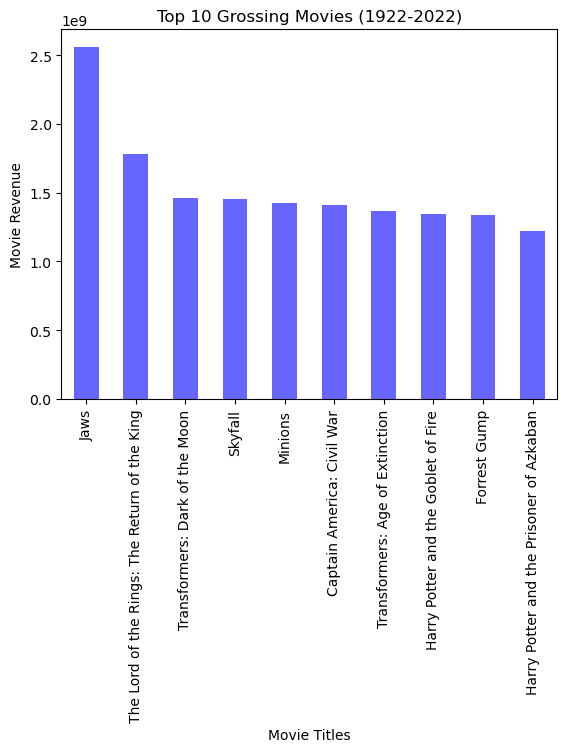

In [51]:
# Create a bar chart to display top 10 grossing movies

top_ten_df.plot("Title", "infl_adj_revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
                xlabel="Movie Titles", ylabel="Movie Revenue", legend='')


# ax=top_ten_df.plot("Title", "revenue", kind='bar', alpha=0.6, color='blue', title="Top 10 Grossing Movies (1922-2022)",
#                 xlabel="Movie Titles", ylabel="Movie Revenue", legend='')
# ax.set_xticklabels(top_ten_df['Title'], rotation=45)
# plt.show()

In [52]:
country_df = movie_list.copy(deep=True)
country_df[['country1', 'country2', 'country3', 'country4', 'country5', 'country6']] = country_df['production_countries'].str.split(', ', expand=True, n=5)
country_df.sample(10)

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
726,726,Wet Hot American Summer,2001,2171,tt0243655,Comedy,97,5000000,295206,United States of America,...,8262422.360248,487823.331056,-7.774599e+06,2000s,United States of America,None,None,None,None,None
318,318,Starship Troopers,1997,563,tt0120201,"Adventure, Action, Thriller, Science Fiction",129,105000000,121214377,United States of America,...,191456542.056075,221021766.360966,2.956522e+07,1990s,United States of America,None,None,None,None,None
552,552,Insurgent,2015,262500,tt2908446,"Action, Adventure, Science Fiction, Thriller",119,110000000,297002527,"Canada, United States of America",...,135821692.114912,366721688.904952,2.309000e+08,2010s,Canada,United States of America,None,None,None,None
392,392,Saving Grace,2000,2360,tt0195234,"Crime, Comedy",93,10000000,26330482,"France, United Kingdom",...,16995063.87921,44748822.356039,2.775376e+07,1990s,France,United Kingdom,None,None,None,None
665,665,Star Trek VI: The Undiscovered Country,1991,174,tt0102975,"Science Fiction, Action, Adventure, Thriller",109,27000000,96900000,United States of America,...,58015308.370044,208210495.594714,1.501952e+08,1990s,United States of America,None,None,None,None,None
21,21,"Come Back to the 5 & Dime, Jimmy Dean, Jimmy Dean",1982,67772,tt0083745,Drama,110,850000,840000,United States of America,...,2577790.15544,2547463.212435,-3.032694e+04,1980s,United States of America,None,None,None,None,None
296,296,Lovey-Dovey 2,2008,62732,tt1414840,"Comedy, Fantasy",100,3000000,17850711,Russia,...,4077811.270628,24263943.501507,2.018613e+07,2000s,Russia,None,None,None,None,None
797,797,Kick-Ass,2010,23483,tt1250777,"Action, Crime",117,28000000,96188903,"United Kingdom, United States of America",...,37579062.259236,129096027.660165,9.151697e+07,2000s,United Kingdom,United States of America,None,None,None,None
530,530,101 Dalmatians,1996,11674,tt0115433,"Family, Comedy",103,54000000,320689294,"United Kingdom, United States of America",...,100722562.141491,598160135.981963,4.974376e+08,1990s,United Kingdom,United States of America,None,None,None,None
705,705,Glory,1989,9665,tt0097441,"Drama, History, War",122,18000000,26828365,United States of America,...,42482177.419355,63318186.766734,2.083601e+07,1980s,United States of America,None,None,None,None,None


In [53]:
country_df2 = country_df.sort_values(by='infl_adj_revenue', ascending=False)
country_df3 = country_df2.iloc[0:50, :]
country_df3

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,infl_adj_budget,infl_adj_revenue,real_profit,Decades,country1,country2,country3,country4,country5,country6
499,499,Jaws,1975,578,tt0073195,"Horror, Thriller, Adventure",124,7000000,470653000,United States of America,...,38077788.104089,2560203600.650558,2.522126e+09,1970s,United States of America,None,None,None,None,None
615,615,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979,"New Zealand, United States of America",...,149508532.608696,1779611163.854592,1.630103e+09,2000s,New Zealand,United States of America,None,None,None,None
903,903,Transformers: Dark of the Moon,2011,38356,tt1399103,"Action, Science Fiction, Adventure",154,195000000,1123794079,United States of America,...,253703115.066751,1462102864.286518,1.208400e+09,2010s,United States of America,None,None,None,None,None
515,515,Skyfall,2012,37724,tt1074638,"Action, Adventure, Thriller",143,200000000,1142471295,"United Kingdom, United States of America",...,254932620.190423,1456266003.633479,1.201333e+09,2010s,United Kingdom,United States of America,None,None,None,None
544,544,Minions,2015,211672,tt2293640,"Family, Animation, Adventure, Comedy",91,74000000,1156730962,United States of America,...,91370956.513668,1428265059.823177,1.336894e+09,2010s,United States of America,None,None,None,None,None
641,641,Captain America: Civil War,2016,271110,tt3498820,"Adventure, Action, Science Fiction",147,250000000,1155046416,United States of America,...,304840067.164708,1408417708.12718,1.103578e+09,2010s,United States of America,None,None,None,None,None
53,53,Transformers: Age of Extinction,2014,91314,tt2109248,"Science Fiction, Action, Adventure",165,210000000,1104054072,United States of America,...,259603735.806975,1364840769.638585,1.105237e+09,2010s,United States of America,None,None,None,None,None
377,377,Harry Potter and the Goblet of Fire,2005,674,tt0330373,"Adventure, Fantasy",157,150000000,895921036,"United Kingdom, United States of America",...,224773425.499232,1342528268.256938,1.117755e+09,2000s,United Kingdom,United States of America,None,None,None,None
64,64,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,...,108610155.195682,1337657908.407422,1.229048e+09,1990s,United States of America,None,None,None,None,None
391,391,Harry Potter and the Prisoner of Azkaban,2004,673,tt0304141,"Adventure, Fantasy",141,130000000,789804554,"United Kingdom, United States of America",...,201403652.72631,1223611708.580571,1.022208e+09,2000s,United Kingdom,United States of America,None,None,None,None


In [54]:
countries = list(country_df3["country1"].unique())
countries

['United States of America',
 'New Zealand',
 'United Kingdom',
 'Canada',
 'Germany']

In [55]:
# # MAP TIME
# # Import dependencies needed for world map visualizations
import matplotlib.pyplot as plt
import hvplot.pandas
import geoviews
import geopandas 

# Load the world map GeoDataFrame
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
# Filter the GeoDataFrame to select the list of top 10 grossing films' production countries

country_data = []
for i in range(len(countries)):
    country_data.append(world[world['name'] == countries[i]])

# Print the USA GeoDataFrame
print(country_data)

[     pop_est      continent                      name iso_a3  gdp_md_est  \
4  326625791  North America  United States of America    USA  18560000.0   

                                            geometry  
4  MULTIPOLYGON (((-122.84000 49.00000, -120.0000...  ,      pop_est continent         name iso_a3  gdp_md_est  \
136  4510327   Oceania  New Zealand    NZL    174800.0   

                                              geometry  
136  MULTIPOLYGON (((176.88582 -40.06598, 176.50802...  ,       pop_est continent            name iso_a3  gdp_md_est  \
143  64769452    Europe  United Kingdom    GBR   2788000.0   

                                              geometry  
143  MULTIPOLYGON (((-6.19788 53.86757, -6.95373 54...  ,     pop_est      continent    name iso_a3  gdp_md_est  \
3  35623680  North America  Canada    CAN   1674000.0   

                                            geometry  
3  MULTIPOLYGON (((-122.84000 49.00000, -122.9742...  ,       pop_est continent     name iso_

/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/carterjackson/anaconda3/lib/python3.11/site-packages/geopandas/plo

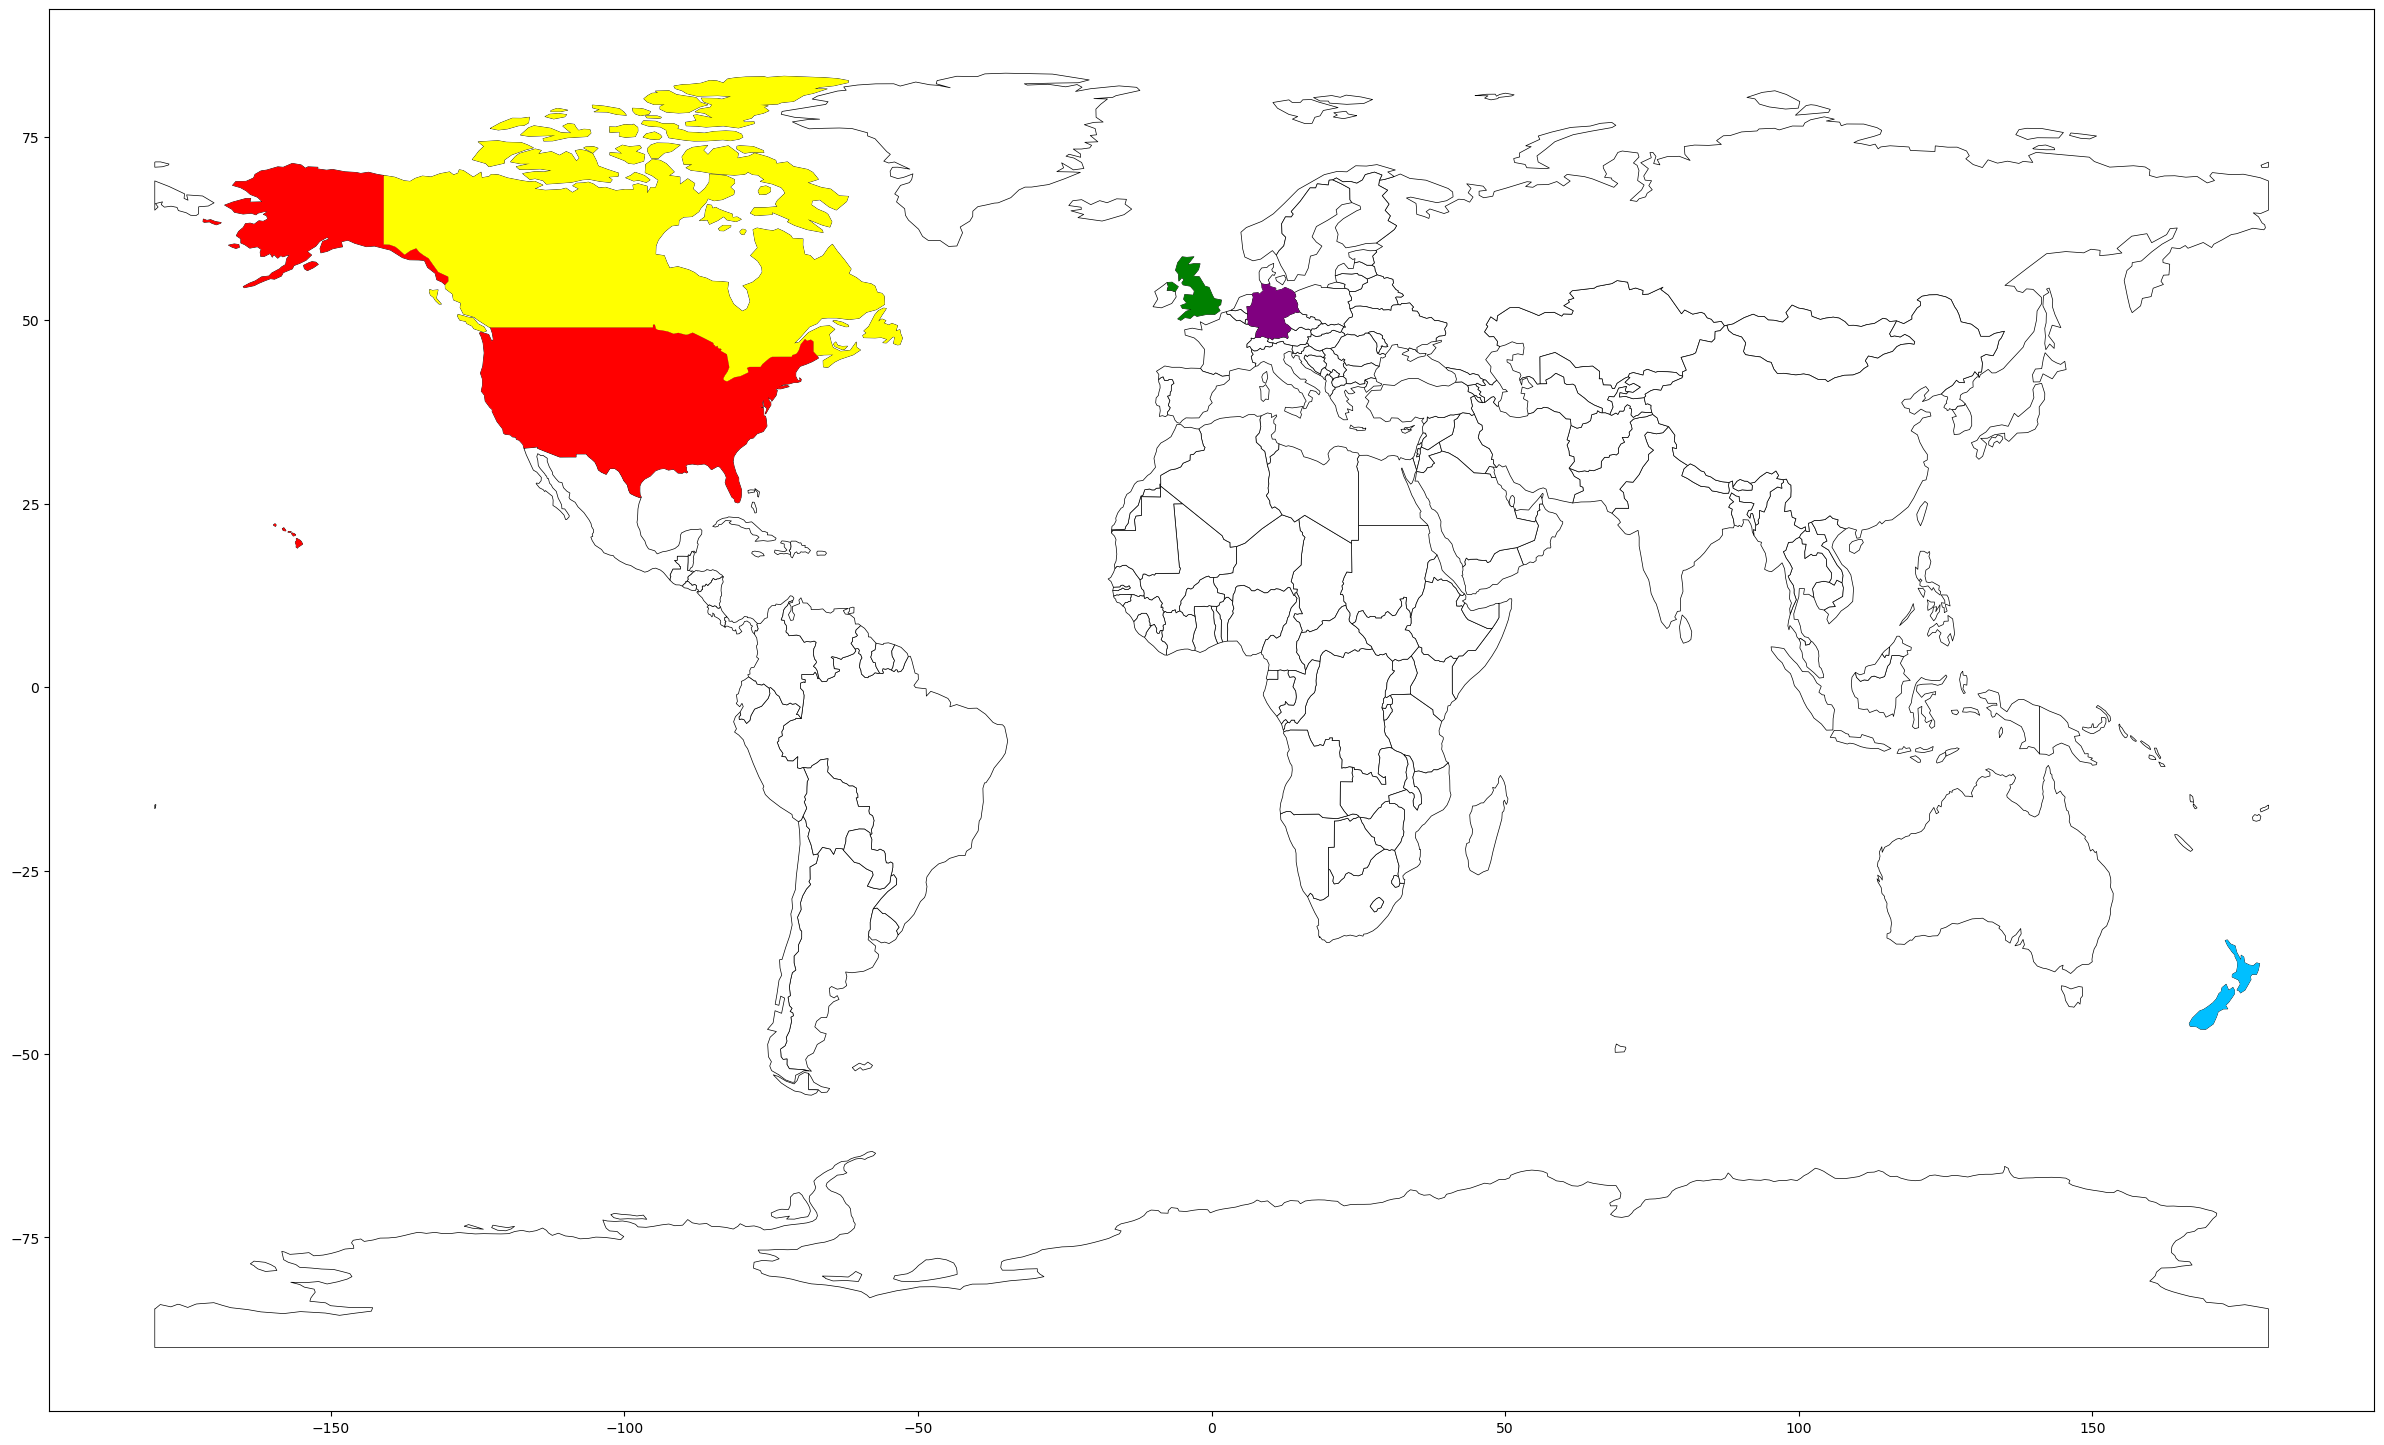

In [57]:
# Create a base world map
world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# Extract the indices
# indices = [index for index, word in indexed_list]

# Create a list of colors to be looped through when plotting the list of countries
colors = ['red', 'deepskyblue', 'green', 'yellow', 'purple', 'orange', 'pink', 'cyan', 'peachpuff', 'gold', 
          'firebrick', 'darkturquoise', 'blueviolet', 'maroon']

for i in range(len(country_data)):
    current_color = colors[i % len(colors)] 
    country_data[i].plot(color=current_color, alpha=1, aspect='1.25', ax=plt.gca())

plt.show()

In [ ]:
# # Create a base world map
# world.plot(color='w', figsize=(30, 20), edgecolor='black', aspect="auto", linewidth=0.5)

# # Assign ascending indices to the length of the list
# indexed_list = list(enumerate(countries))

# # Extract the indices
# indices = [index for index, word in indexed_list]

# # Plot the United States in a different color

# for i in range(len(country_data)):
#     for_alpha=(0.1*float(indices[i]))+0.2
#     country_data[i].plot(color='blue', alpha=for_alpha, aspect='1.25', ax=plt.gca())

# plt.show()

<Axes: title={'center': 'Number of Movies per decade'}, xlabel='Decades', ylabel='Number of Movies'>

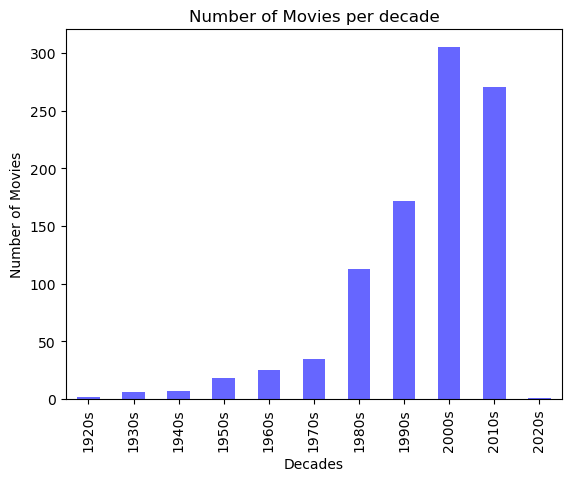

In [58]:
# Create a bar chart based upon the above data
y_axis=movie_list.groupby('Decades').count()['Title']
y_axis.plot(kind='bar', alpha=0.6, color='blue', title="Number of Movies per decade", xlabel="Decades", ylabel="Number of Movies")

## Pie Chart

In [59]:
# Minimum Budget
min_budget = movie_list['infl_adj_budget'].min()
# Average Budget
avg_budget = movie_list['infl_adj_budget'].mean()
# Maximum Budget
max_budget = movie_list['infl_adj_budget'].max()
diff = (max_budget-min_budget)/3
# Define the bins and labels
bins=[min_budget,round(min_budget+diff),round(min_budget+2*diff),round(min_budget+3*diff)]
labels = ['Low Budget', 'Average Budget', 'High Budget']
# Cut the 'Budget' column into categories and create a new column 'Budget_Category'
movie_list['Budget_Category'] = pd.cut(movie_list['infl_adj_budget'], bins=bins, labels=labels)
movie_list.sample(10)

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
748,748,The Frighteners,1996,10779,tt0116365,"Horror, Comedy",110,30000000,29359216,"New Zealand, United States of America",18.814,6.884,7.1,"93,257",55956978.967495,54761767.740472,-1.195211e+06,1990s,Low Budget
150,150,The Best Exotic Marigold Hotel,2012,74534,tt1412386,"Drama, Comedy",124,10000000,136836156,"United Arab Emirates, United Kingdom, United S...",11.131,6.938,7.2,"98,131",12746631.009521,174419998.929327,1.616734e+08,2010s,Low Budget
731,731,Recep Ivedik,2008,31060,tt1193516,Comedy,102,500000,28548025,Turkey,5.863,4.856,4.8,"28,076",679635.211771,38804486.033056,3.812485e+07,2000s,Low Budget
267,267,God's Not Dead 2,2016,347126,tt4824308,"Drama, Fantasy",121,5000000,23507567,United States of America,24.446,6.100,4.3,"13,188",6096801.343294,28664193.212635,2.256739e+07,2010s,Low Budget
707,707,Get Rich or Die Tryin',2005,10060,tt0430308,"Drama, Crime, Music",117,40000000,46442528,United States of America,18.332,6.700,5.4,"48,979",59939580.133129,69593640.716027,9.654061e+06,2000s,Low Budget
623,623,The Hurricane,1999,10400,tt0174856,Drama,146,50000000,73956241,United States of America,14.107,7.436,7.6,"100,645",87831632.653061,129913947.838265,4.208232e+07,1990s,Low Budget
709,709,A Good Day to Die Hard,2013,47964,tt1606378,"Action, Thriller",98,92000000,304654182,United States of America,97.181,5.300,5.2,"212,298",115576093.442137,382725437.02576,2.671493e+08,2010s,Average Budget
447,447,Blue Thunder,1983,6341,tt0085255,"Drama, Action, Thriller",110,22000000,42313354,United States of America,15.696,6.136,6.4,"22,806",64642670.682731,124329464.004719,5.968679e+07,1980s,Low Budget
636,636,Vanishing Point,1971,11951,tt0067927,"Action, Drama",99,1300000,72266306,United States of America,13.481,7.189,7.2,"29,976",9393864.197531,522199895.862469,5.128060e+08,1970s,Low Budget
421,421,Live and Let Die,1973,253,tt0070328,"Adventure, Action, Thriller",121,7000000,126377836,United Kingdom,23.134,6.486,6.7,"112,746",46139301.801802,832997873.751802,7.868586e+08,1970s,Low Budget


  Budget_Category  count
0      Low Budget    800
1  Average Budget    125
2     High Budget     26


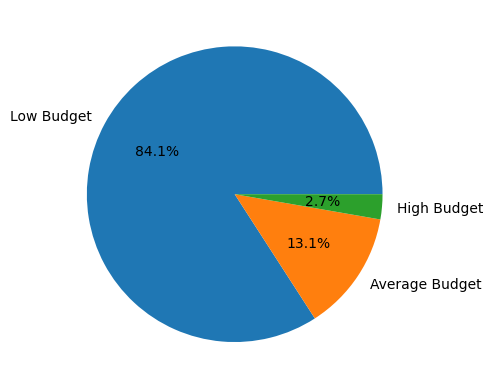

In [60]:
# Pie plot showing the distribution of Budget category using pyplot
budget_distribution = movie_list['Budget_Category'].value_counts().reset_index()
print(budget_distribution)
#create y label
y = [budget_distribution['count'][0],budget_distribution['count'][1],budget_distribution['count'][2]]
#Show Pie Plot
plt.pie(y,autopct='%1.1f%%',labels=['Low Budget','Average Budget','High Budget'])
plt.show()

In [61]:
genre_df = movie_list.copy(deep=True)
# genre_df
genre_df[['primary_genre', 'sub_genre_1', 'sub_genre_2', 'sub_genre_3', 'sub_genre_4', 'sub_genre_5']] = genre_df['genres'].str.split(', ', expand=True, n=5)
genre_df

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,infl_adj_revenue,real_profit,Decades,Budget_Category,primary_genre,sub_genre_1,sub_genre_2,sub_genre_3,sub_genre_4,sub_genre_5
0,0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,...,70964609.907663,3.915428e+07,2000s,Low Budget,Family,Comedy,Drama,None,None,None
1,1,Land of the Lost,2009,18162,tt0457400,"Adventure, Comedy, Science Fiction",102,100000000,68688831,United States of America,...,93700060.298713,-4.271231e+07,2000s,Average Budget,Adventure,Comedy,Science Fiction,None,None,None
2,2,Don't Say a Word,2001,12103,tt0260866,"Thriller, Mystery",113,50000000,100020092,"Australia, Switzerland, United States of America",...,165281648.922981,8.265743e+07,2000s,Low Budget,Thriller,Mystery,None,None,None,None
3,3,Man on a Ledge,2012,49527,tt1568338,"Action, Thriller, Crime",102,42000000,46221189,United States of America,...,58916444.100434,5.380594e+06,2010s,Low Budget,Action,Thriller,Crime,None,None,None
4,4,The Wedding Singer,1998,11003,tt0120888,"Romance, Comedy",100,18000000,123306987,United States of America,...,221388995.585797,1.890713e+08,1990s,Low Budget,Romance,Comedy,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
949,949,Due Date,2010,41733,tt1231583,"Comedy, Drama",95,65000000,211780824,United States of America,...,284233027.514583,1.969959e+08,2000s,Low Budget,Comedy,Drama,None,None,None,None
950,950,Batman v Superman: Dawn of Justice,2016,209112,tt2975590,"Action, Adventure, Fantasy",152,250000000,873637528,United States of America,...,1065278890.852517,7.604388e+08,2010s,NaN,Action,Adventure,Fantasy,None,None,None
951,951,Clockers,1995,20649,tt0112688,"Mystery, Crime, Drama",128,25000000,13071518,United States of America,...,25101345.802428,-2.290636e+07,1990s,Low Budget,Mystery,Crime,Drama,None,None,None
952,952,Spellbound,1945,4174,tt0038109,"Thriller, Mystery, Romance, Drama",111,1500000,7000000,United States of America,...,113810277.777778,8.942236e+07,1940s,Low Budget,Thriller,Mystery,Romance,Drama,None,None


In [62]:

# colors = plt.cm.Paired(range(len(primary_genre)))
primary_genre = genre_df['primary_genre'].value_counts()
primary_genre_length = len(primary_genre)

# Make blank list for explode values and loop through the primary genre length to append 0 after 0.1 accordingly
explode = []
for i in range(primary_genre_length):
    if i == 0:
        explode.append(0.1)
    else:
        explode.append(0)
print(f"Number of primary genres: {len(primary_genre)}")
primary_genre

Number of primary genres: 18


primary_genre
Comedy             201
Drama              199
Action             179
Adventure           75
Horror              62
Crime               49
Thriller            43
Romance             28
Science Fiction     19
Animation           18
Fantasy             16
Family              14
Mystery             11
Western             11
Music               10
Documentary         10
War                  7
History              2
Name: count, dtype: int64

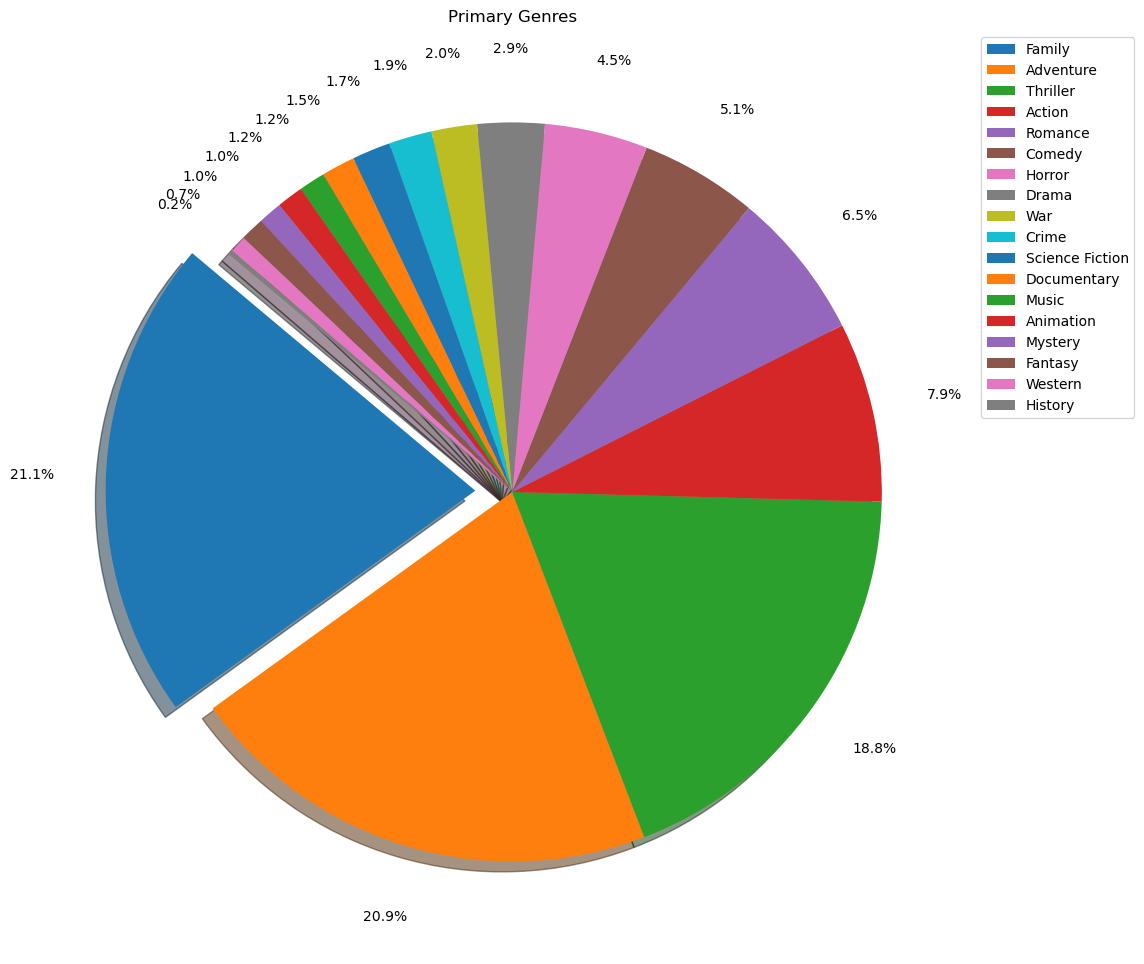

In [63]:
plt.figure(figsize=(12, 12))
categories = genre_df['primary_genre'].unique()
# This code would be to include 'exploding' the biggest value out but has an error when 'explode' list is not equal
# to length of primary genres
plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2, explode=explode)
# plt.pie(primary_genre, autopct= "%1.1f%%", shadow=True, startangle=140, pctdistance=1.2)
plt.legend(categories, loc='best', bbox_to_anchor=(1, 1))
plt.title('Primary Genres')
plt.show()

## Bar Plot

<Figure size 1000x200 with 0 Axes>

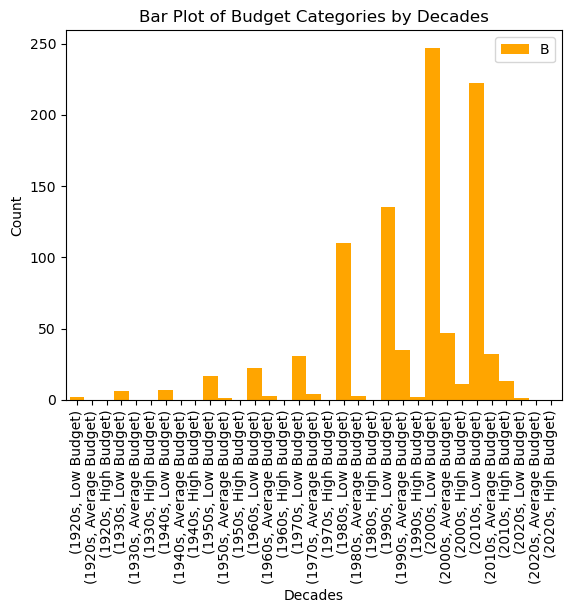

In [65]:
#Bar plot Budget Categories by Decades
grouped_df = movie_list.groupby(['Decades', 'Budget_Category'])['Title'].count().reset_index()
pivot_df=grouped_df.set_index(['Decades', 'Budget_Category'])
# Set the figure size
plt.figure(figsize=(10,2))  # Width, Height in inches
# Create a stacked bar plot
pivot_df.plot(kind='bar',width=1,color='orange', stacked=True)
# Add labels and a title
plt.xlabel('Decades')
plt.ylabel('Count')
plt.title('Bar Plot of Budget Categories by Decades')
plt.legend("Budget")
# Show the plot
plt.show()

## Histogram Plotting

Text(0.5, 1.0, 'Histogram of Budget')

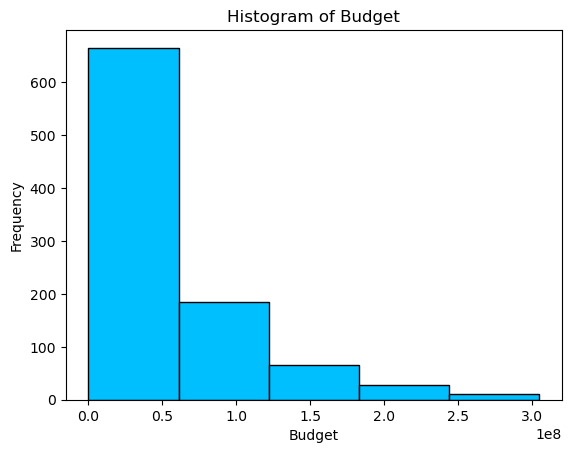

In [66]:
# Plot a histogram of budget
plt.hist(movie_list['infl_adj_budget'],bins=5, color='deepskyblue', edgecolor='k')
plt.xlabel('Budget')
plt.ylabel('Frequency')
plt.title('Histogram of Budget')

In [67]:
# 
from scipy.stats import shapiro
DataToTest = movie_list['infl_adj_budget']
stat,p = shapiro(DataToTest)
print(f"stat: {stat},p: {p}")
if(p>0.05):
    print("Accept NULL Hypothesis: Budget data is not normally Distributed")
else:
    print("Reject NULL Hypothesis: Budget data is not normally Distributed")

stat: 0.8152458667755127,p: 1.0906738523016985e-31
Reject NULL Hypothesis: Budget data is not normally Distributed


## Scatter Plots with Linear Regression

In [68]:
# Creating a function for computing linear regression
def lin_regress(xval, yval, x_label, y_label): 
    x_values = xval
    y_values = yval
    
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    plt.scatter(x_values,y_values, c='blueviolet')
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.plot(x_values,regress_values,"r-")
    plt.annotate(line_eq,(10,20),fontsize=15,color="red")
    plt.legend(['Regression Line: y = {:.2f}x + {:.2f}'.format(slope, intercept)])
    print("The r-value is: ",rvalue)
    plt.show()
#     x_values = 0
#     y_values = 0

The r-value is:  -0.11109221023228956


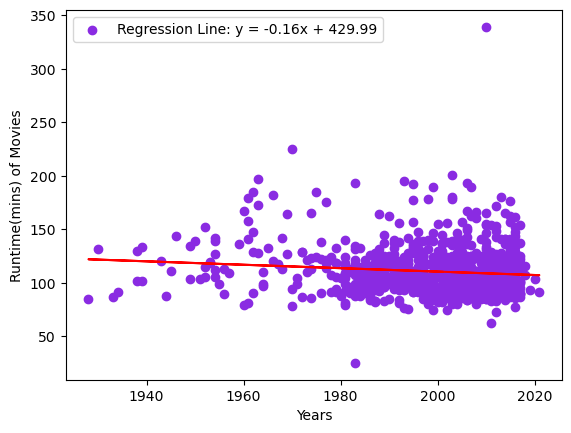

In [69]:
# Create a scatter plot for regression analysis

xval = movie_list['Year']
yval = movie_list['runtime'].astype(int)
x_label='Years'
y_label='Runtime(mins) of Movies'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.04207451716844671


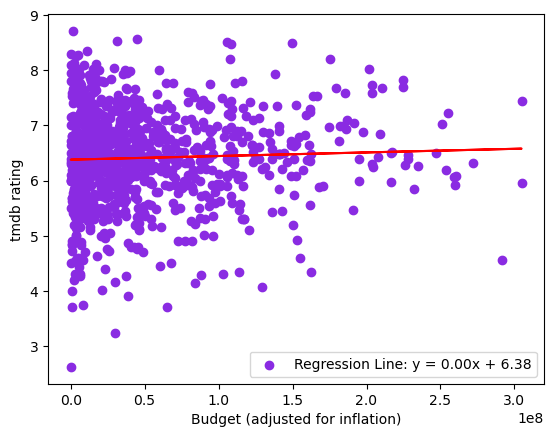

In [70]:
# Create a scatter plot for regression analysis: Budget vs. tmdb

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['tmdb_rating'].astype(float)
x_label='Budget (adjusted for inflation)'
y_label='tmdb rating'

lin_regress(xval, yval, x_label, y_label)

In [71]:
movie_list['imdb_rating'].unique()

array([6.2, 5.3, 6.3, 6.6, 6.9, 6.8, 6. , 4.2, 5.5, 5.9, 5.7, 7.5, 8.2,
       6.4, 7.1, 7.9, 5.4, 7.2, 7. , 6.7, 7.8, 5.1, 7.6, 5.6, 4.7, 3.3,
       5.8, 8.1, 7.3, 3.4, 8.8, 4.5, 7.7, 7.4, 6.5, 3.6, 5. , 8. , 4.8,
       4.3, 3.8, 5.2, 4.9, 6.1, 8.6, 8.4, 8.3, 4.6, 4.1, 4.4, 8.5, 2.5,
       2.1, 3.9, 2.2, 3.1, 9. , 2.4, 3.7, 8.9, 8.7])

The r-value is:  -0.004989296717191464


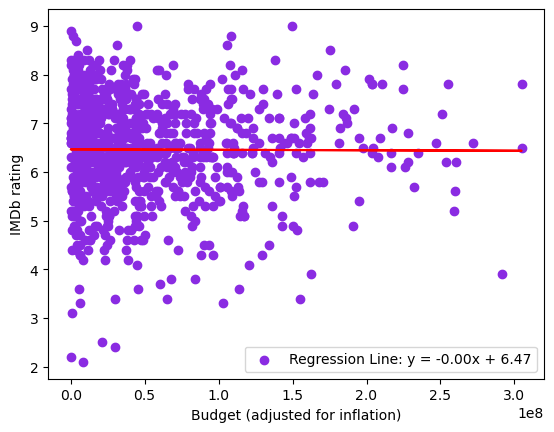

In [72]:
# Create a scatter plot for regression analysis: Budget vs. imbd Rating

xval = movie_list['infl_adj_budget'].astype(int)
yval = movie_list['imdb_rating'].astype(float)
x_label='Budget (adjusted for inflation)'
y_label='IMDb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.21132896537104037


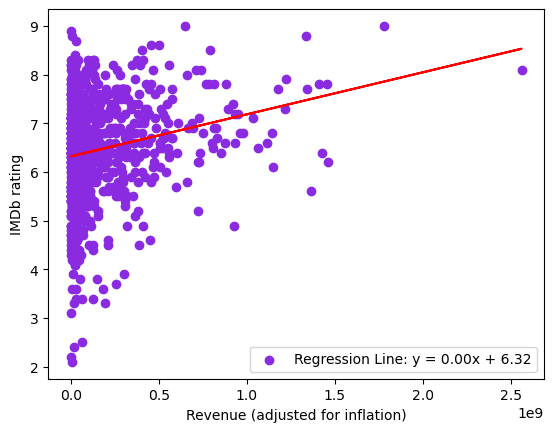

In [73]:
# Create a scatter plot for regression analysis: Revenue vs. imbd Rating

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['imdb_rating'].astype(float)
x_label='Revenue (adjusted for inflation)'
y_label='IMDb rating'

lin_regress(xval, yval, x_label, y_label)

The r-value is:  0.25277844521228215


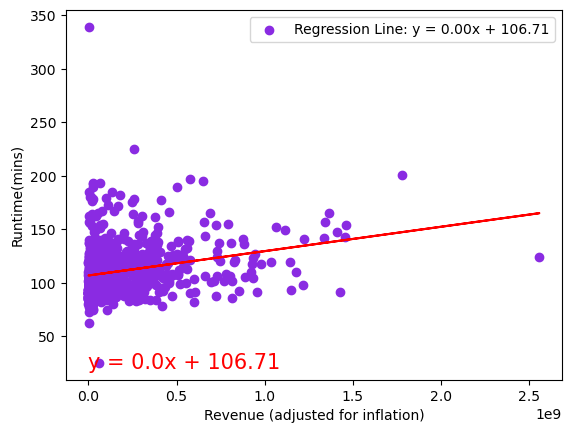

In [74]:
# Create a scatter plot for regression analysis: Revenue vs. Runtime

xval = movie_list['infl_adj_revenue'].astype(float)
yval = movie_list['runtime'].astype(int)
x_label='Revenue (adjusted for inflation)'
y_label='Runtime(mins)'

lin_regress(xval, yval, x_label, y_label)

# Data Testing

## 

In [75]:
#TEST NULL HYPOTHESIS(budget and revenue)
#H0: There is a significant association between budget and revenue of a movie.
#H1: There is no significant association between budget and revenue of a movie
from scipy.stats import chi2_contingency

# Create a contingency table
contingency_table = pd.crosstab(movie_list['infl_adj_budget'], movie_list['infl_adj_revenue'])

# Perform the chi-square test for independence
chi2, p, _, _ = chi2_contingency(contingency_table)

print("Chi-Square Statistic:", chi2)
print("P-value:", p)

alpha = 0.05  # Significance level

if p < alpha:
    print("Accept Null Hypothesis: There is no significant association between budget and revenue of a movie.")
else:
    print("Reject Null Hypothesis: There is no significant association between budget and revenue of a movie.")

Chi-Square Statistic: 765346.4999999997
P-value: 0.0004510024142456112
Accept Null Hypothesis: There is a significant association between budget and revenue of a movie.


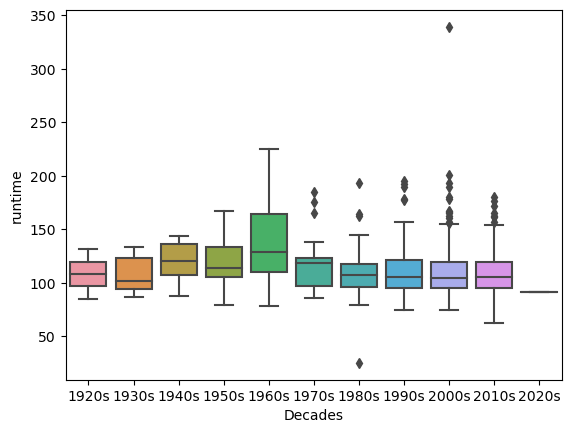

In [76]:
#Identifying Outliers in Movie Runtimes Over the Years
import seaborn as sns
ax = sns.boxplot(x='Decades',y='runtime',data=movie_list)

# Incorporating Oscar and Golden Globe Data

### Oscar dataset import and cleaning

In [77]:
# Import the Oscar csv to analyze
oscar_list = pd.read_csv("the_oscar_award.csv")
print(oscar_list.shape)
oscar_list.head(2)

(10765, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
0,1927,1928,1,ACTOR,Richard Barthelmess,The Noose,False
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True


In [78]:
# Check for NaN values in the film column of the Oscar List
oscar_list["film"].isnull().value_counts()

film
False    10450
True       315
Name: count, dtype: int64

In [79]:
# Drop the NaN values and the "False" winners to clean the data
oscar_list.dropna(how="any", inplace=True)
oscar_winners = oscar_list["winner"]==True

oscars = oscar_list[oscar_winners]
print(oscars.shape)
oscars

(2149, 7)


,year_film,year_ceremony,ceremony,category,name,film,winner
1,1927,1928,1,ACTOR,Emil Jannings,The Last Command,True
3,1927,1928,1,ACTRESS,Janet Gaynor,7th Heaven,True
6,1927,1928,1,ART DIRECTION,William Cameron Menzies,The Dove;,True
9,1927,1928,1,CINEMATOGRAPHY,Charles Rosher,Sunrise,True
10,1927,1928,1,CINEMATOGRAPHY,Karl Struss,Sunrise,True
...,...,...,...,...,...,...,...
10743,2022,2023,95,SOUND,"Mark Weingarten, James H. Mather, Al Nelson, C...",Top Gun: Maverick,True
10745,2022,2023,95,VISUAL EFFECTS,"Joe Letteri, Richard Baneham, Eric Saindon and...",Avatar: The Way of Water,True
10753,2022,2023,95,WRITING (Adapted Screenplay),Screenplay by Sarah Polley,Women Talking,True
10755,2022,2023,95,WRITING (Original Screenplay),Written by Daniel Kwan & Daniel Scheinert,Everything Everywhere All at Once,True


In [80]:
# Count the number of wins each film has and turn that series into a DataFrame
oscar_wins = oscars[["film", "year_film"]].value_counts()
oscar_win_df = oscar_wins.reset_index()
oscar_win_df

,film,year_film,count
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


In [81]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
oscar_win_df = oscar_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Oscar_Wins'})
oscar_win_df

,Title,Year,Oscar_Wins
0,Titanic,1997,11
1,Ben-Hur,1959,11
2,The Lord of the Rings: The Return of the King,2003,11
3,West Side Story,1961,10
4,The Last Emperor,1987,9
...,...,...,...
1325,Knighty Knight Bugs,1958,1
1326,Kokoda Front Line!,1942,1
1327,Kolya,1996,1
1328,Kon-Tiki,1951,1


### Golden Globe dataset import and cleaning

In [82]:
# Import the golden globes csv to analyze
gglobe_list = pd.read_csv("golden_globe_awards.csv")
print(gglobe_list.shape)
gglobe_list.head()

# gglobe_list

(7991, 7)


,year_film,year_award,ceremony,category,nominee,film,win
0,1943,1944,1,Best Performance by an Actress in a Supporting...,Katina Paxinou,For Whom The Bell Tolls,True
1,1943,1944,1,Best Performance by an Actor in a Supporting R...,Akim Tamiroff,For Whom The Bell Tolls,True
2,1943,1944,1,Best Director - Motion Picture,Henry King,The Song Of Bernadette,True
3,1943,1944,1,Picture,The Song Of Bernadette,NaN,True
4,1943,1944,1,Actress In A Leading Role,Jennifer Jones,The Song Of Bernadette,True


In [83]:
# Check for NaN values in the film column of the Golden Globe List
gglobe_list["film"].isnull().value_counts()

film
False    6191
True     1800
Name: count, dtype: int64

In [84]:
# Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
gglobe_winners = gglobe_list["win"]==True
# gglobe_winners
gglobes = gglobe_list[gglobe_winners]

# Update the 'film' column where it is NaN with values from the 'nominee' column
gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])
gglobes.sample(10)

# print(gglobes.shape)
# gglobes

/var/folders/_2/7g_mshsj32ndtynd6y83mpgr0000gn/T/ipykernel_95568/1505913114.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gglobes['film'] = gglobes['film'].fillna(gglobes['nominee'])


,year_film,year_award,ceremony,category,nominee,film,win
601,1959,1960,17,New Star Of The Year - Actor,Barry Coe,"Private's Affair, A",True
7499,2016,2017,74,Best Performance by an Actor in a Motion Pictu...,Casey Affleck,Manchester by the Sea,True
5722,2002,2003,60,Best Motion Picture - Drama,The Hours,The Hours,True
302,1955,1956,13,New Star Of The Year - Actor,Ray Danton,I'll Cry Tomorrow,True
4910,1995,1996,53,Best Television Limited Series or Motion Pictu...,Indictment: The McMartin Trial,Indictment: The McMartin Trial,True
6777,2010,2011,68,Best Motion Picture - Animated,Toy Story 3,Toy Story 3,True
2541,1976,1977,34,New Star Of The Year - Actor,Arnold Schwarzenegger,Stay Hungry,True
383,1956,1957,14,Henrietta Award (World Film Favorites),James Dean,James Dean,True
2355,1975,1976,33,Best Television Series - Drama,Kojak,Kojak,True
1641,1970,1971,28,Best Performance by an Actress in a Motion Pic...,Ali MacGraw,Love Story,True


In [ ]:
# # Drop the NaN values and the "False" winners to clean the data
# gglobe_list.dropna(how="any", inplace=True)
# gglobe_winners = gglobe_list["win"]==True
# gglobe_winners

# gglobes = gglobe_list[gglobe_winners]
# print(gglobes.shape)
# gglobes

In [85]:
# Count the number of wins each film has and turn that series into a DataFrame
gglobe_count = gglobes[["film", "year_film"]].value_counts()
gglobe_win_df = gglobe_count.reset_index()
gglobe_win_df

,film,year_film,count
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


In [86]:
# Rename the columns of the DataFrame to cleanly merge with the movie data
gglobe_win_df = gglobe_win_df.rename(columns={'film': 'Title', 'year_film': 'Year', 'count': 'Golden_Globe_Wins'})
gglobe_win_df

,Title,Year,Golden_Globe_Wins
0,La La Land,2016,7
1,Lawrence Of Arabia,1962,6
2,One Flew Over The Cuckoo's Nest,1975,6
3,Midnight Express,1978,6
4,Ordinary People,1980,5
...,...,...,...
1324,House,2006,1
1325,House of Cards,2013,1
1326,House of Cards,2014,1
1327,House of Lies,2012,1


## Merging the Oscars and Golden Globes DataFrames into the Movie List DataFrame

In [87]:
# Referencing the movie_list for ease of coding
print(movie_list.shape)
movie_list.head(1)

(954, 19)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category
0,0,Uptown Girls,2003,14926,tt0263757,"Family, Comedy, Drama",92,20000000,44617342,United States of America,16.036,6.64,6.2,"41,464",31810326.086957,70964609.907663,3.915428e+07,2000s,Low Budget


In [88]:
# Individually merge the Oscars and Golden Globes DataFrames into the master movie list
oscar_awards = pd.merge(movie_list, oscar_win_df, how="inner", on=["Title", "Year"])
print(oscar_awards.shape)
oscar_awards.head()

(76, 20)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins
0,17,Babel,2006,1164,tt0449467,Drama,143,25000000,135330182,"France, Mexico, United States of America",15.327,7.181,7.5,"312,941",36291542.65873,196453642.922669,1.601621e+08,2000s,Low Budget,1
1,22,The Adventures of Robin Hood,1938,10907,tt0029843,"Adventure, Romance, History",102,2033000,3981000,United States of America,17.403,7.400,7.9,"53,429",42196284.751773,82628337.234043,4.043205e+07,1930s,Low Budget,3
2,25,The Guns of Navarone,1961,10911,tt0054953,"War, Action, Adventure",158,6000000,28900000,"United Kingdom, United States of America",11.862,7.308,7.5,"54,020",58726755.852843,282867207.357859,2.241405e+08,1960s,Low Budget,1
3,29,Big Hero 6,2014,177572,tt2245084,"Adventure, Family, Animation, Action, Comedy",102,165000000,657827828,United States of America,98.084,7.737,7.8,"486,738",203974363.848337,813212198.412324,6.092378e+08,2010s,High Budget,1
4,61,RoboCop,1987,5548,tt0093870,"Action, Thriller, Science Fiction",102,13000000,53424681,United States of America,32.606,7.298,7.6,"272,981",33490448.943662,137632042.412456,1.041416e+08,1980s,Low Budget,1


In [89]:
gglobe_awards = pd.merge(movie_list, gglobe_win_df, how="inner", on=["Title", "Year"])
print(gglobe_awards.shape)
gglobe_awards.head()

(49, 20)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,popularity,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Golden_Globe_Wins
0,17,Babel,2006,1164,tt0449467,Drama,143,25000000,135330182,"France, Mexico, United States of America",15.327,7.181,7.5,"312,941",36291542.65873,196453642.922669,1.601621e+08,2000s,Low Budget,1
1,42,Pretty Woman,1990,114,tt0100405,"Comedy, Romance",119,14000000,463406268,United States of America,43.326,7.451,7.1,"344,227",31347895.944912,1037629390.677429,1.006281e+09,1980s,Low Budget,1
2,64,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,61.235,8.477,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Average Budget,3
3,90,Working Girl,1988,3525,tt0096463,"Comedy, Romance, Drama",114,28000000,103173635,United States of America,12.512,6.588,6.8,"60,848",69267455.621302,255234827.987532,1.859674e+08,1980s,Low Budget,4
4,92,Scent of a Woman,1992,9475,tt0105323,Drama,156,31000000,134095253,United States of America,24.405,7.768,8.0,"318,144",64663613.684961,279712375.386422,2.150488e+08,1990s,Low Budget,3


In [90]:
# Make a DataFrame merging Golden Globe Awards data onto the merged Oscar data to show only films with wins in both
both_awards = pd.merge(oscar_awards, gglobe_win_df, how="inner", on=["Title", "Year"])
print(both_awards.shape)
both_awards

(36, 21)


,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,tmdb_rating,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins
0,17,Babel,2006,1164,tt0449467,Drama,143,25000000,135330182,"France, Mexico, United States of America",...,7.181,7.5,"312,941",36291542.65873,196453642.922669,1.601621e+08,2000s,Low Budget,1,1
1,64,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,...,8.477,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Average Budget,6,3
2,90,Working Girl,1988,3525,tt0096463,"Comedy, Romance, Drama",114,28000000,103173635,United States of America,...,6.588,6.8,"60,848",69267455.621302,255234827.987532,1.859674e+08,1980s,Low Budget,1,4
3,92,Scent of a Woman,1992,9475,tt0105323,Drama,156,31000000,134095253,United States of America,...,7.768,8.0,"318,144",64663613.684961,279712375.386422,2.150488e+08,1990s,Low Budget,1,3
4,135,No Country for Old Men,2007,6977,tt0477348,"Crime, Drama, Thriller",122,25000000,171627166,United States of America,...,7.935,8.2,"1,025,064",35286507.316414,242244929.950179,2.069584e+08,2000s,Low Budget,4,2
5,171,Network,1976,10774,tt0074958,Drama,122,3800000,23689877,United States of America,...,7.800,8.1,"166,278",19544622.144112,121844656.475132,1.023000e+08,1970s,Low Budget,4,4
6,200,Silver Linings Playbook,2012,82693,tt1045658,"Drama, Comedy, Romance",122,21000000,236412453,United States of America,...,7.129,7.7,"729,799",26767925.119994,301346230.444676,2.745783e+08,2010s,Low Budget,1,1
7,205,Gosford Park,2001,5279,tt0280707,"Drama, Mystery, Thriller",137,19800000,87754044,"Italy, United States of America",...,6.857,7.2,"91,795",32719192.546584,145012195.069565,1.122930e+08,2000s,Low Budget,1,1
8,220,Midnight Express,1978,11327,tt0077928,"Drama, Crime",121,2300000,35000000,"United Kingdom, United States of America",...,7.524,7.5,"86,165",10323719.325153,157100076.687117,1.467764e+08,1970s,Low Budget,2,6
9,241,Gods and Monsters,1998,3033,tt0120684,Drama,105,10000000,6451628,"United Kingdom, United States of America",...,6.949,7.3,"32,366",17954294.478528,11583442.897791,-6.370852e+06,1990s,Low Budget,1,1


In [91]:
# Sum the Oscar and Golden Globe Award wins into a new column called cumulative awards
both_awards['Cumulative_Awards'] = ''
for index,row in both_awards.iterrows():
    both_awards.loc[index, "Cumulative_Awards"] = both_awards.loc[index,'Oscar_Wins']+both_awards.loc[index,'Golden_Globe_Wins']

both_awards.sort_values(by='Cumulative_Awards',ascending = False,inplace=True)
both_awards.head(50)

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
25,615,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979,"New Zealand, United States of America",...,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s,Average Budget,11,4,15
23,578,Schindler's List,1993,424,tt0108052,"Drama, History, War",195,22000000,321365567,United States of America,...,9.0,"1,410,062",44556470.588235,650859792.459412,6.063033e+08,1990s,Low Budget,7,3,10
22,559,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000,United States of America,...,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4,9
1,64,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,...,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Average Budget,6,3,9
5,171,Network,1976,10774,tt0074958,Drama,122,3800000,23689877,United States of America,...,8.1,"166,278",19544622.144112,121844656.475132,1.023000e+08,1970s,Low Budget,4,4,8
8,220,Midnight Express,1978,11327,tt0077928,"Drama, Crime",121,2300000,35000000,"United Kingdom, United States of America",...,7.5,"86,165",10323719.325153,157100076.687117,1.467764e+08,1970s,Low Budget,2,6,8
11,244,Gladiator,2000,98,tt0172495,"Action, Drama, Adventure",155,103000000,465361176,"United Kingdom, United States of America",...,8.5,"1,566,334",175049157.955865,790884291.302439,6.158351e+08,1990s,Average Budget,5,3,8
14,378,Brokeback Mountain,2005,142,tt0388795,"Drama, Romance",134,14000000,178043761,"Canada, United States of America",...,7.7,"372,854",20978853.046595,266796706.991577,2.458179e+08,2000s,Low Budget,3,4,7
13,308,The Revenant,2015,281957,tt1663202,"Western, Drama, Adventure",157,135000000,532950503,"Canada, Hong Kong, Taiwan, United States of Am...",...,8.0,"845,222",166690258.504664,658056719.372302,4.913665e+08,2010s,Average Budget,3,3,6
4,135,No Country for Old Men,2007,6977,tt0477348,"Crime, Drama, Thriller",122,25000000,171627166,United States of America,...,8.2,"1,025,064",35286507.316414,242244929.950179,2.069584e+08,2000s,Low Budget,4,2,6


In [92]:
# Sort the data descending and grab the top 20 cumulative winners to do visualizations with
top20_both_awards = both_awards.sort_values(by='Cumulative_Awards', ascending=False)
top20_movies = top20_both_awards.iloc[0:20, :] 
top20_movies.head()

,index,Title,Year,id,imdb_id,genres,runtime,budget,revenue,production_countries,...,imdb_rating,imdb_votes,infl_adj_budget,infl_adj_revenue,real_profit,Decades,Budget_Category,Oscar_Wins,Golden_Globe_Wins,Cumulative_Awards
25,615,The Lord of the Rings: The Return of the King,2003,122,tt0167260,"Adventure, Fantasy, Action",201,94000000,1118888979,"New Zealand, United States of America",...,9.0,"1,920,154",149508532.608696,1779611163.854592,1.630103e+09,2000s,Average Budget,11,4,15
23,578,Schindler's List,1993,424,tt0108052,"Drama, History, War",195,22000000,321365567,United States of America,...,9.0,"1,410,062",44556470.588235,650859792.459412,6.063033e+08,1990s,Low Budget,7,3,10
22,559,Kramer vs. Kramer,1979,12102,tt0079417,Drama,105,8000000,106260000,United States of America,...,7.8,"151,535",32248484.848485,428340500.0,3.960920e+08,1970s,Low Budget,5,4,9
1,64,Forrest Gump,1994,13,tt0109830,"Comedy, Drama, Romance",142,55000000,677387716,United States of America,...,8.8,"2,183,967",108610155.195682,1337657908.407422,1.229048e+09,1990s,Average Budget,6,3,9
5,171,Network,1976,10774,tt0074958,Drama,122,3800000,23689877,United States of America,...,8.1,"166,278",19544622.144112,121844656.475132,1.023000e+08,1970s,Low Budget,4,4,8


<BarContainer object of 20 artists>

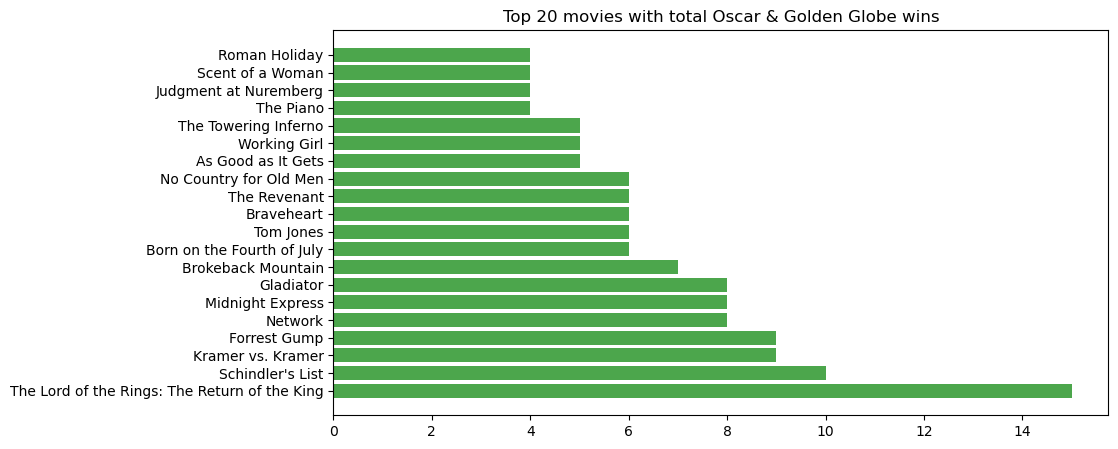

In [93]:
# plt.barh(x, y)
x=top20_movies['Title']
y=top20_movies['Cumulative_Awards']
plt.figure(figsize=(10,5))
plt.title('Top 20 movies with total Oscar & Golden Globe wins')
plt.barh(x,y,color='green',alpha=0.7)

In [94]:
# Take a look at how many awards were won by each decade
per_decade_wins=both_awards['Decades'].value_counts()
per_decade_wins

Decades
1990s    13
2000s     6
1970s     5
1980s     4
2010s     4
1950s     2
1960s     2
1920s     0
1930s     0
1940s     0
2020s     0
Name: count, dtype: int64

<BarContainer object of 11 artists>

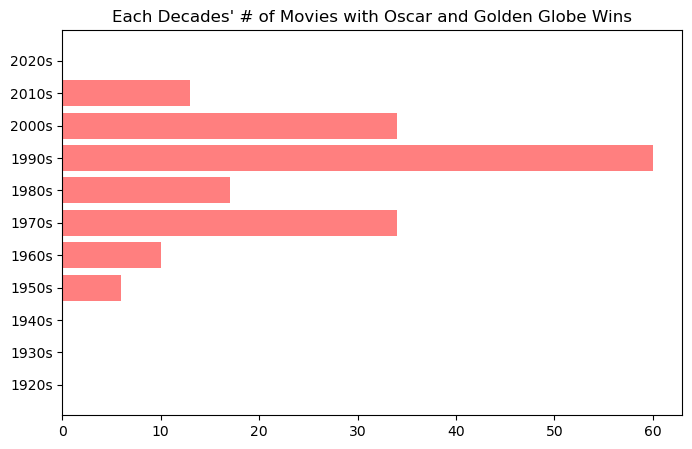

In [95]:
# Bar plot for cumulative Oscar and Golden Globe wins by Decade
decade_groupby = both_awards.groupby('Decades')
decades_sum=decade_groupby['Cumulative_Awards'].sum().reset_index()
decades_sum['Cumulative_Awards']
x=decades_sum['Decades']
y=decades_sum['Cumulative_Awards']
#plt.xlabel("Total oscar and golden globe wins")

plt.figure(figsize=(8,5))
plt.title(f"Each Decades' # of Movies with Oscar and Golden Globe Wins")
plt.barh(x,y,color='red',alpha=0.5)

### Pulling genre and produciton country information out of the DataFrame

In [ ]:
# # Testing the Pandas "explode" function
# checkexplode = movie_list["genres"].explode('drama')
# checkexplode